#FIXME:
* path to dea logo
* location of supp data hird.shp and the workflow image
* check requirements for NCI compatibility
* check special requirements and prerequisites are filled out in the next cell
* test funky permissions error
* replace/ update flow chart

# Introduction to the DEA Wetlands Insight Tool <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with `DEA Sandbox` environment only
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls_wo_3](https://explorer.sandbox.dea.ga.gov.au/products/ga_ls_wo_3),
[ga_ls_fc_3](https://explorer.sandbox.dea.ga.gov.au/products/ga_ls_fc_3),


* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook


This notebook demonstrates the method for reproducing results from the Wetlands Insight Tool.

<div id='svgWrapper'>
    <img src='infra/WIT_processing.svg'/>
</div>

## Background

Wetlands provide a wide range of ecosystem services including improving water quality, carbon sequestration, as well as providing habitat for fish, amphibians, reptiles and birds.  Managing wetlands in Australia is challenging due to competing pressures for water availability and highly variable climatic settings.  The DEA Wetlands Insight Tool has been developed to provide catchment managers, environmental water holders, and wetlands scientists a consistent historical baseline of wetlands dynamics from 1987 onwards. 

The DEA Wetlands Insight Tool summarises how the amount of water, green vegetation, dry vegetation and bare soil varies over time within each wetland. It provides the user with the ability to compare how the wetland is behaving now with how it has behaved in the past.  This allows users to identify how changes in water availability have affected the wetland. It achieves this by presenting a combined view of Water Observations from Space, Tasseled Cap Wetness and Fractional Cover measurements from the Landsat series of satellites, summarised as a stacked line plot to show how that wetland has changed over time. 

Wetlands Insight Tool stacked line plot for a seasonally inundated wetland

## Applications
The product is designed to support QLD wetland managers, catchment managers and environmental waterholders in understanding whether or not wetlands are changing over time.  In instances where the wetlands are changing, the tool allows users to identify whether the changes are gradual, rapid, once-off or cyclical in nature.  For example the response of wetlands to the following drivers can be assessed:

Changes in river flow volumes
Changes in flood frequency
Long term shifts in rainfall
Wet-season/Dry-season shifts in water availability
Invasive weeds
Environmental watering events
Care should be used when interpreting Wetlands Insight Tool (QLD) results as increases/decreases in particular cover types can be associated with different processes.  For example an increase in green cover could indicate canopy recovery of desirable wetland species or an increase in the amount of invasive weeds.

## Related products
DEA Fractional Cover (Landsat, DEPRECATED)
DEA Wetness Percentiles (Landsat)
DEA Water Observations (Landsat, DEPRECATED)

## Setup

Import packages:

In [1]:
import itertools

import datacube
import dea_tools.datahandling
import dea_tools.bandindices
from dea_tools.spatial import xr_rasterize
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd

Connect to the datacube:

In [2]:
dc = datacube.Datacube(app='witbook')

## Data loading

Load a shapefile with the polygon of interest:

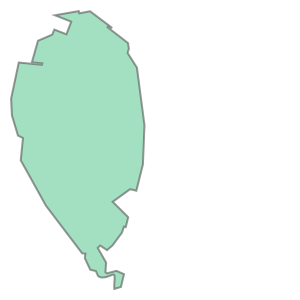

In [3]:
poly = gpd.read_file('hird/hird.shp')
poly.geometry[0]

In [4]:
poly.geometry[0].area

4336813.220362894

...and specify a time period to examine:

In [5]:
time = ('2014-10-01', '2015-01-01')

Then load Landsat, Water Observations, and Fractional Cover:

In [6]:
bands = [f'nbart_{band}' for band in ('blue', 'green', 'red', 'nir', 'swir_1', 'swir_2')]

In [7]:
gpgon = datacube.utils.geometry.Geometry(poly.geometry[0], crs=poly.crs)

In [8]:
ds = dea_tools.datahandling.load_ard(dc, products=['ga_ls8c_ard_3', 'ga_ls7e_ard_3', 'ga_ls5t_ard_3'], ls7_slc_off=False, measurements=bands,
                                     geopolygon=gpgon,
                                     output_crs='EPSG:3577', resolution=(-30, 30), resampling={'fmask': 'nearest', '*': 'bilinear'},
                                     time=time, group_by='solar_day')

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Loading 12 time steps


In [9]:
ds_wo = dc.load('ga_ls_wo_3', resampling='nearest', group_by='solar_day', like=ds)
ds_fc = dc.load('ga_ls_fc_3', resampling='nearest', group_by='solar_day', like=ds)

Find any missing observations:

In [10]:
missing = set()
for t1, t2 in itertools.product(
        [ds_fc.time.values, ds_wo.time.values, ds.time.values], repeat=2):
    missing_ = set(t1) - set(t2)
    missing |= missing_

...and delete them:

In [11]:
ds_fc = ds_fc.sel(time=[t for t in ds_fc.time.values if t not in missing])
ds = ds.sel(time=[t for t in ds.time.values if t not in missing])
ds_wo = ds_wo.sel(time=[t for t in ds_wo.time.values if t not in missing])

Finally, calculate Tasseled-Cap Wetness:

In [12]:
tcw = dea_tools.bandindices.calculate_indices(
    ds, index='TCW', collection='ga_ls_3',
    normalise=False, drop=True, inplace=False)

Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


## WIT calculation

For each pixel, we calculate its WIT values based on the Flowchart from Dunn et al. (in prep).

Divide out the FC values by 100 to keep them in $[0, 1]$ (ignoring for now that values can exceed 100 due to how FC is calculated):

In [13]:
bs = ds_fc.bs / 100
pv = ds_fc.pv / 100
npv = ds_fc.npv / 100

Generate the WIT raster bands:

In [14]:
rast_names = ['pv', 'npv', 'bs', 'wet', 'water']
output_rast = {n: xr.zeros_like(bs) for n in rast_names}

output_rast['bs'].values[:] = bs
output_rast['pv'].values[:] = pv
output_rast['npv'].values[:] = npv

Mask cloudy/cloud shadowy/noncontiguous/no-data pixels and pixels not in the polygon:

In [15]:
poly_raster = xr_rasterize(poly, pv) > 0

# refs to: https://github.com/GeoscienceAustralia/dea-conflux/blob/main/examples/wit_ls5.conflux.py#L66

###
# https://github.com/GeoscienceAustralia/wofs/blob/3eacdc8b5b5c399fbe780cb9289e71b7d6ded31c/wofs/constants.py

#                    0           no water present
#     1              1<<0        nodata (missing all earth observation bands)
#     2              1<<1        noncontiguous (at least one EO band is missing or saturated)
#     4              1<<2        low solar incidence angle
#     8              1<<3        terrain shadow
#     16             1<<4        high slope
#     32             1<<5        cloud shadow
#     64             1<<6        cloud
#     128            1<<7        classified as water by the decision tree

###

mask = (ds_wo.water & 0b01100011) == 0
mask &= poly_raster

open_water = ds_wo.water & (1 << 7) > 0

wet = tcw.where(mask).TCW > -350

In [16]:
poly_raster

<xarray.DataArray (y: 127, x: 61)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * y            (y) float64 -3.968e+06 -3.968e+06 ... -3.972e+06 -3.972e+06
  * x            (x) float64 1.09e+06 1.09e+06 1.09e+06 ... 1.091e+06 1.091e+06
    spatial_ref  int32 3577

In [17]:
# TCW
output_rast['wet'].values[:] = wet.values.astype(float)
for name in rast_names[:3]:
    output_rast[name].values[wet.values] = 0

In [18]:
# WO
output_rast['water'].values[:] = open_water.values.astype(float)
for name in rast_names[:4]:
    output_rast[name].values[open_water.values] = 0

In [19]:
ds_wit = xr.Dataset(output_rast).where(mask)

In [20]:
ds_wit.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:      (time: 12, y: 127, x: 61)
Coordinates:
  * time         (time) datetime64[ns] 2014-10-04T00:09:25.149376 ... 2014-12...
  * y            (y) float64 -3.968e+06 -3.968e+06 ... -3.972e+06 -3.972e+06
  * x            (x) float64 1.09e+06 1.09e+06 1.09e+06 ... 1.091e+06 1.091e+06
    spatial_ref  int32 3577
Data variables:
    pv           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    npv          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    bs           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    wet          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    water        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan>

Mask entire observations where the polygon is more than 10% masked:

In [21]:
pc_missing = (~mask).where(poly_raster).mean(dim=['x', 'y'])

In [22]:
ds_wit = ds_wit.where(pc_missing < 0.1)

The WIT results are now computed. All that's left is to normalise them.

## Normalise WIT result example

In [23]:
# A polygon has 11 pixels


# [cloud][water][wet][wet][wet][wet][wet][wet][wet][wet][vegetation]
#   |      |        |                                        |
#   |      |        |                                        |
#   |      |        |__> wet = 8/10 = 80%                    |__> pv/npv/bs == 1/10 = 10%
#   |      |
#   |      |__> water = 1/10 = 10% 
#   |
#   |__> pc_missing = 1/11 ~+ 9.1%

In [24]:
# The vegetation pixel relative np, npv, and bs values

# [vegetation]
#      |
#      |__> [pv] [npv] [bs]
#           [ 5] [  4] [ 2]

In [25]:
# Assume vegetation relative values are:

water = 0.1
wet = 0.8

pv = 0.05
npv = 0.04
bs = 0.02

vegetation_area = 1 - water - wet

vegetation_overall_value = pv + npv + bs

print(f"The pv is {pv} \nThe npv is {npv} \nThe bs is {bs} \nThe overall number is {water + wet + pv + npv + bs}")

The pv is 0.05 
The npv is 0.04 
The bs is 0.02 
The overall number is 1.01


In [26]:
pv = pv/vegetation_overall_value*vegetation_area
npv = npv/vegetation_overall_value*vegetation_area
bs = bs/vegetation_overall_value*vegetation_area

In [27]:
print(f"The normalised pv is {pv} \nThe normalised npv is {npv} \nThe normalised bs is {bs} \nThe normalised overall number is {water + wet + pv + npv + bs}")

The normalised pv is 0.04545454545454545 
The normalised npv is 0.036363636363636355 
The normalised bs is 0.018181818181818177 
The normalised overall number is 1.0


In [28]:
# covert ds_wit: XArray.Dataset to polygon_base_df: pandas.DataFrame
# Then we can reuse the following codes in dea-conflux stack step

polygon_base_df = pd.DataFrame()
polygon_base_df['date'] = ds_wit.time.values

for band in rast_names:
    polygon_base_df[band] = ds_wit[band].mean(dim=['x', 'y'])

In [29]:
def normalise_wit(polygon_base_df):
    # ignore high pixel missing timestamp result
    polygon_base_df = polygon_base_df.dropna(subset=['bs'])
    
    # 1. compute the expected vegetation area total size: 1 - water (%) - wet (%)    
    polygon_base_df.loc[:, "veg_areas"] = 1 - polygon_base_df['water'] - polygon_base_df['wet']
    
    # 2. normalse the vegetation values based on vegetation size (to handle FC values more than 100 issue)
    # WARNNING: Not touch the water and wet, cause they are pixel classification result
    polygon_base_df.loc[:, "overall_veg_num"] = polygon_base_df['pv'] + polygon_base_df['npv'] + polygon_base_df['bs']
    
    # 3. if the overall_veg_num is 0, no need to normalize veg area
    norm_veg_index = polygon_base_df["overall_veg_num"] != 0
    
    for band in ["bs", "pv", "npv"]:
        polygon_base_df.loc[:, "norm_" + band] = polygon_base_df.loc[:, band]
        polygon_base_df.loc[norm_veg_index, "norm_" + band] = (
            polygon_base_df.loc[norm_veg_index, band]
            / polygon_base_df.loc[norm_veg_index, "overall_veg_num"]
            * polygon_base_df.loc[norm_veg_index, "veg_areas"]
        )
    
    # convert the string to Python datetime format, easy to do display the result in PNG
    polygon_base_df.loc[:, "date"] = pd.to_datetime(polygon_base_df["date"], infer_datetime_format=True)
    
    polygon_base_df.reset_index(inplace=True)
    
    return polygon_base_df

In [30]:
polygon_base_df = normalise_wit(polygon_base_df)

/tmp/ipykernel_251/2125865703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polygon_base_df.loc[:, "veg_areas"] = 1 - polygon_base_df['water'] - polygon_base_df['wet']
/tmp/ipykernel_251/2125865703.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polygon_base_df.loc[:, "overall_veg_num"] = polygon_base_df['pv'] + polygon_base_df['npv'] + polygon_base_df['bs']
/tmp/ipykernel_251/2125865703.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [31]:
def generate_low_quality_data_periods(df):
    # the generate_low_quality is: SLC off period: https://www.usgs.gov/faqs/what-landsat-7-etm-slc-data
    # and periods with an observation density of less than four observations within a twelve month (365 days) period
    
    # default: all data points are good
    df.loc[:, "off_value"] = 0
    
    # Add the first no-data times (SLC-off only)
    LS5_8_gap_start = datetime.datetime(2011,11,1)
    LS5_8_gap_end = datetime.datetime(2013,4,1)
    
    df.loc[df[(df['date'] >= LS5_8_gap_start) & (df['date'] <= LS5_8_gap_end)].index, "off_value"] = 100
    
    # periods with an observation density of less than four observations within a twelve month (365 days) period
    for i in range(3, len(df) - 3):               
        # can change to another threshold (like: 100 days) to test dyanmic no-data-period display
        if ((df.loc[i + 3, "date"] - df.loc[i, "date"]).days) > 365:
            df.loc[df[(df['date'] >= df.loc[i, "date"]) & (df['date'] <= df.loc[i + 3, "date"])].index, "off_value"] = 100
                                                         
    return df

## Aspatial display

In [32]:
def display_wit_stack_with_df(polygon_base_df, polygon_name="ANAE_name", width=32, height=6):
    plt.rcParams['axes.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['text.usetex'] = False
    
    fig = plt.figure()
    fig.set_size_inches(width, height)
    ax = fig.add_subplot(111)
    ax.autoscale(enable=True)

    pal = [sns.xkcd_rgb["cobalt blue"],
           sns.xkcd_rgb["neon blue"],
           sns.xkcd_rgb["grass"],
           sns.xkcd_rgb["beige"],
           sns.xkcd_rgb["brown"]]  

    plt.title(f"Percentage of area dominated by WOfS, Wetness, Fractional Cover for\n {polygon_name}", fontsize=16)
    
    ax.stackplot(polygon_base_df["date"], polygon_base_df["water"]*100, polygon_base_df["wet"]*100, polygon_base_df["norm_pv"]*100, polygon_base_df["norm_npv"]*100, polygon_base_df["norm_bs"]*100, colors=pal, alpha=0.7)

    # manually change the legend display order
    legend  = ax.legend(["open water", "wet", "green veg", "dry veg", "bare soil"][::-1], loc='lower left')
    handles = legend.legendHandles
    
    for i, handle in enumerate(handles):
        handle.set_facecolor(pal[::-1][i])
        handle.set_alpha(0.7)
    
    # setup the display ranges
    ax.set_ylim(0, 100)
    ax.set_xlim(polygon_base_df["date"].min(), polygon_base_df["date"].max())
    
    # add a new column: 'off_value' based on low quality data setting
    polygon_base_df = generate_low_quality_data_periods(polygon_base_df)
    
    ax.fill_between(polygon_base_df["date"], 0, 100, where=polygon_base_df["off_value"] == 100, color='white', alpha=0.5, hatch="//")
    
    # modify the xaxis settings
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    x_label_text = "The Fractional Cover algorithm developed by the Joint Remote Sensing Research Program and\n the Water Observations from Space algorithm developed by Geoscience Australia are used in the production of this data"
    
    ax.set_xlabel(x_label_text, style='italic')
    
    #plt.savefig(f"{png_name}.png", bbox_inches='tight')
    plt.show()
    
    plt.close(fig)

/tmp/ipykernel_251/1313612786.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = legend.legendHandles


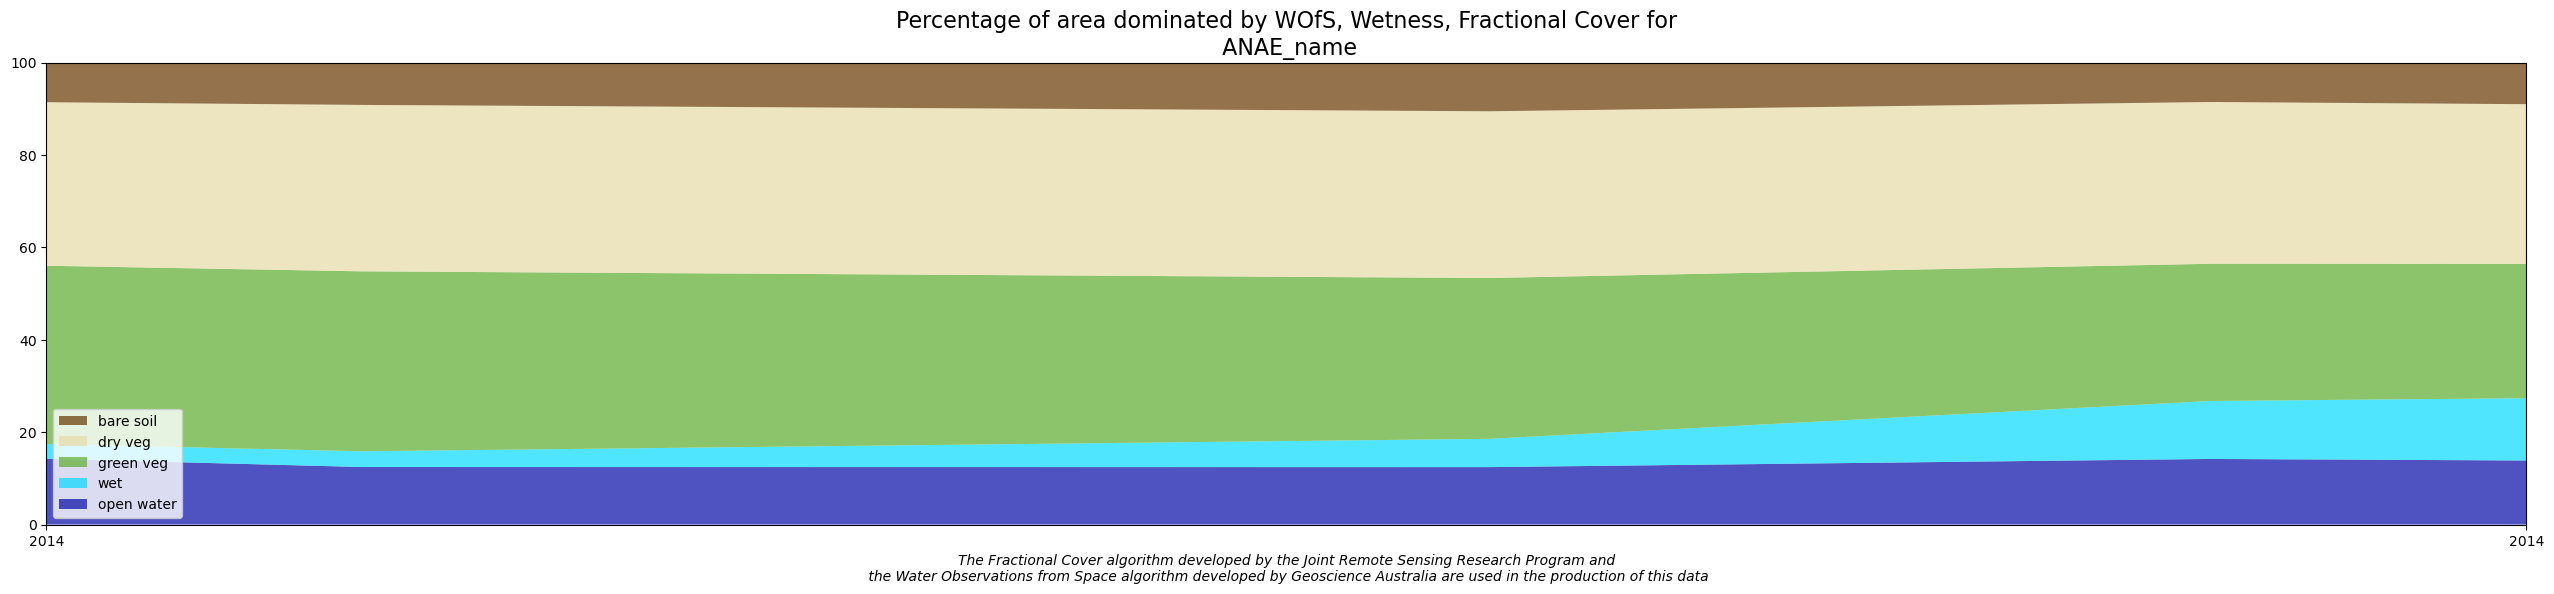

In [33]:
display_wit_stack_with_df(polygon_base_df)